<a href="https://colab.research.google.com/github/sultan-0897/spam_detection_project/blob/main/spam_detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Output figures will be saved to: /content/output/figures
Data shape: (4601, 58)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_hash,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


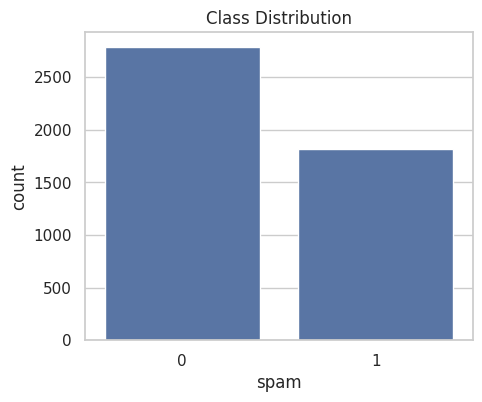

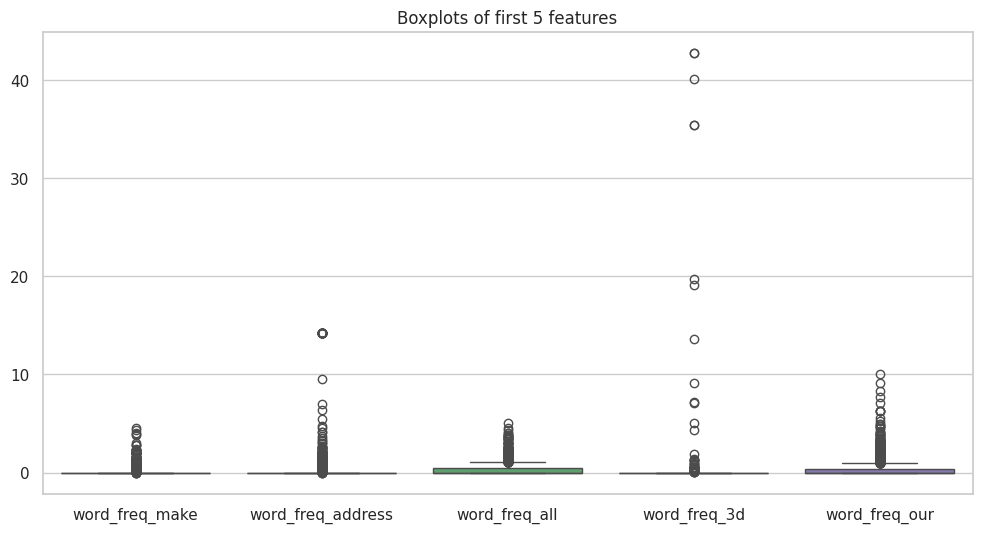

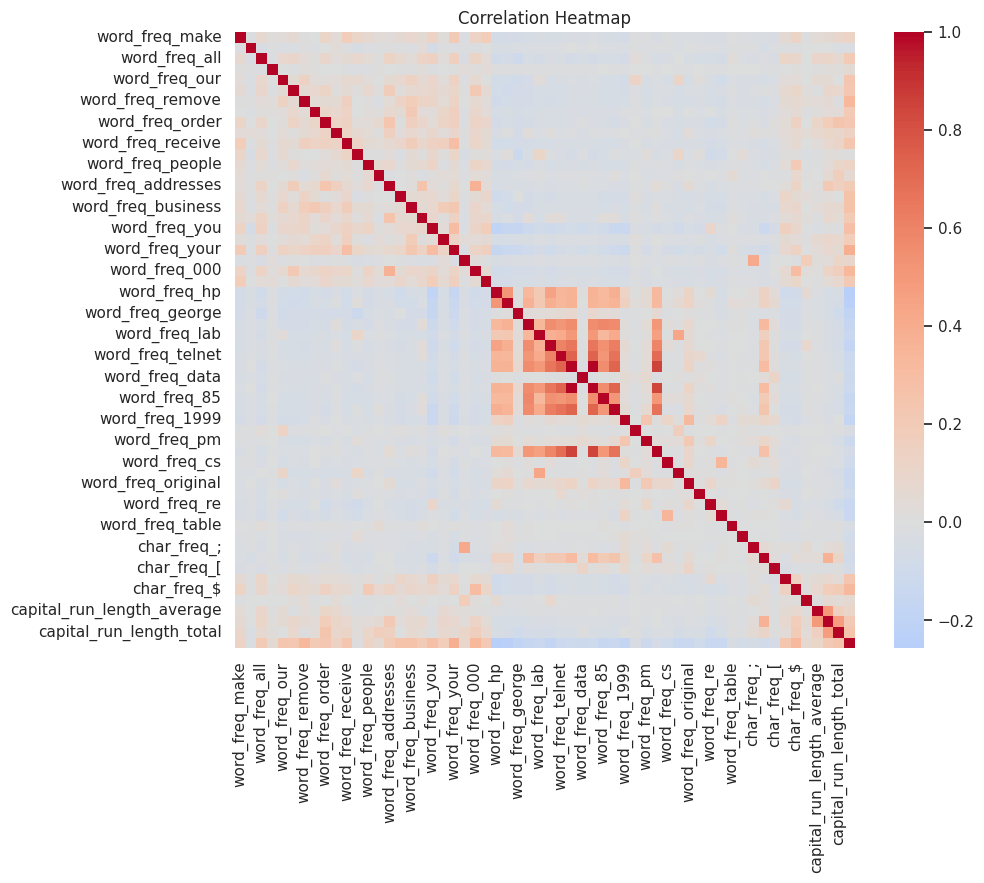


=== KNN ===


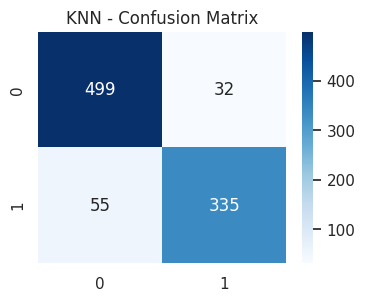

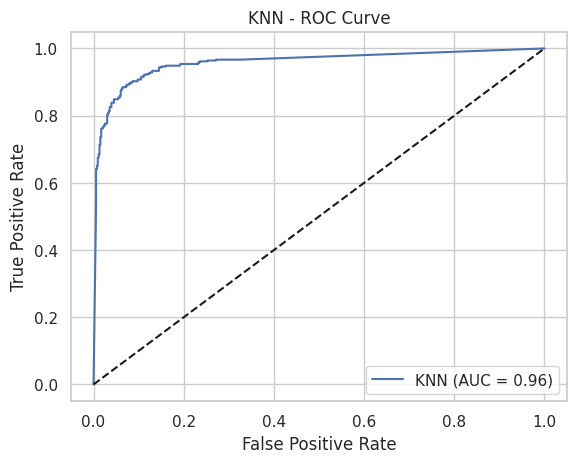


=== LogisticRegression ===


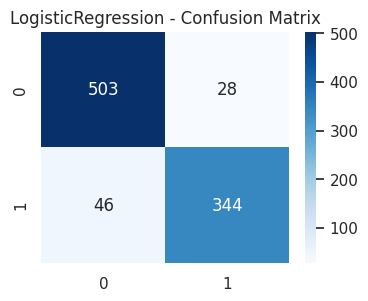

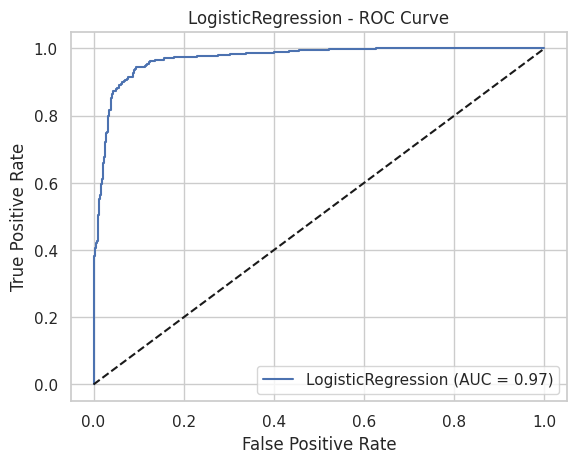


=== RandomForest ===


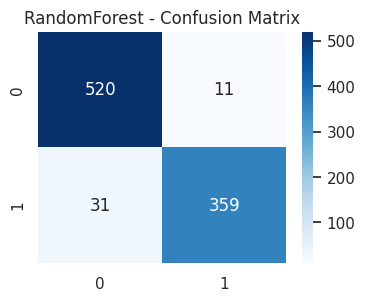

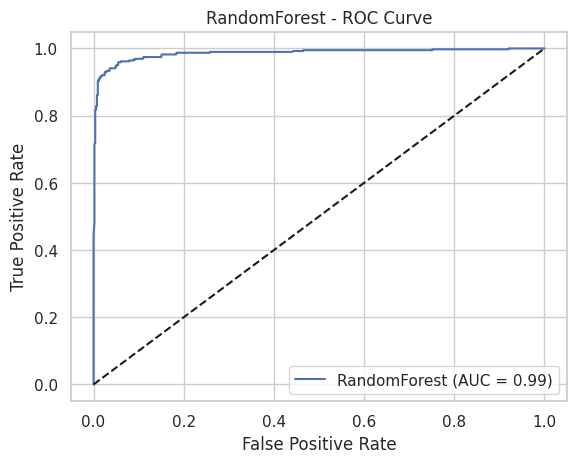


Final Results:


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,KNN,0.905537,0.912807,0.858974,0.885073,0.957893
1,LogisticRegression,0.919653,0.924731,0.882051,0.902887,0.970390
2,RandomForest,0.954397,0.970270,0.920513,0.944737,0.985888


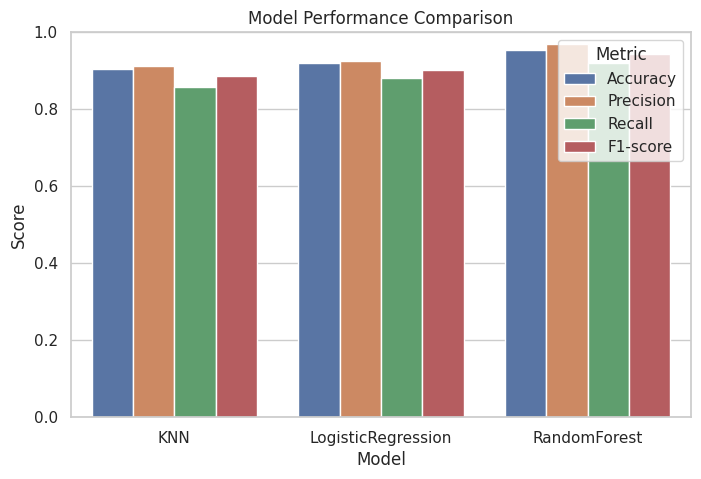

In [2]:
# ================================
# Spam Detection — KNN, LR, RF
# Colab-ready version
# ================================

# --- Imports ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix
)

sns.set(style="whitegrid")

# --- Settings for Colab ---
# Upload your "Spam Detection.csv" via the left sidebar in Colab BEFORE running this
DATA_PATH = "/content/Spam Detection.csv"

OUT_DIR = "/content/output"
FIG_DIR = os.path.join(OUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

print("Output figures will be saved to:", FIG_DIR)

# --- Load Dataset ---
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
display(df.head())

# --- EDA: Class distribution ---
plt.figure(figsize=(5,4))
sns.countplot(x='spam', data=df)
plt.title("Class Distribution")
plt.savefig(os.path.join(FIG_DIR, "fig_class_distribution.png"))
plt.show()

# --- EDA: Boxplots for first few features ---
plt.figure(figsize=(12,6))
sns.boxplot(data=df.iloc[:, :5])
plt.title("Boxplots of first 5 features")
plt.savefig(os.path.join(FIG_DIR, "boxplots_selected.png"))
plt.show()

# --- EDA: Correlation heatmap ---
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.savefig(os.path.join(FIG_DIR, "correlation_heatmap.png"))
plt.show()

# --- Preprocessing ---
X = df.drop(columns=['spam'])
y = df['spam']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# --- Model definitions and parameter grids ---
models = {
    "KNN": (KNeighborsClassifier(), {
        "n_neighbors": [3, 5, 7],
        "weights": ["uniform", "distance"]
    }),
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        "C": [0.01, 0.1, 1, 10]
    }),
    "RandomForest": (RandomForestClassifier(), {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20]
    })
}

results = []

# --- Train, evaluate and save figures ---
for name, (model, params) in models.items():
    print(f"\n=== {name} ===")
    grid = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "ROC-AUC": auc
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.savefig(os.path.join(FIG_DIR, f"cm_{name.lower()}.png"))
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.savefig(os.path.join(FIG_DIR, f"roc_{name.lower()}.png"))
    plt.show()

# --- Results Summary ---
results_df = pd.DataFrame(results)
print("\nFinal Results:")
display(results_df)

# Bar plot of metrics (Accuracy, Precision, Recall, F1-score)
metrics_melted = results_df.melt(id_vars="Model",
                                  value_vars=["Accuracy", "Precision", "Recall", "F1-score"],
                                  var_name="Metric", value_name="Score")
plt.figure(figsize=(8,5))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric")
plt.ylim(0,1)
plt.title("Model Performance Comparison")
plt.savefig(os.path.join(FIG_DIR, "metrics_bar.png"))
plt.show()
